# Overall Methodology

* As a first step, I have used CLIP's encoding for images to get the feature vectors for the images in the dataset.

* Then I saved the feature vectors as numpy arrays, and loaded them later for creating the vector database.

* Then I used CLIP's text encoder to transform the query string into a vector, and used cosine similarity to comapare the vector of query with the image vector for each image.

* The image with the highest cosine similarity is returned

* For generating description given a query, I have used Mistral-7B-v0.1

## Installing package dependencies

In [ ]:
# install the necessary libraries

'''Please Restart the session after running this cell'''
!pip install -q accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 6.7 MB/s eta 0:00:00


In [ ]:
!pip install -q datasets[vision]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00


## Import the required packages

In [ ]:
import os
import torch
import skimage
import requests
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import IPython.display
import matplotlib.pyplot as plt
from datasets import load_dataset, concatenate_datasets, load_from_disk
from collections import OrderedDict
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer, AutoTokenizer

from sklearn.metrics.pairwise import cosine_similarity

## Section 1

### Vector Database creation

Dataset Link: https://huggingface.co/datasets/nateraw/pascal-voc-2012



In [ ]:
# Implement the function to create vector database

def get_single_image_embedding(my_image):
  '''Helper function to get vector embeddings of a single image'''

  image = processor(
      text = None,
      images = my_image["image"],
      return_tensors="pt"
    )["pixel_values"].to(device)
  embedding = model.get_image_features(image)
  embedding_as_np = embedding.cpu().detach().numpy()
  return embedding_as_np

def get_all_images_embedding(df, img_column):
  '''Helper function to get vector embeddings for the whole dataset'''

  df["img_embeddings"] = df[str(img_column)].apply(get_single_image_embedding)
  return df

def create_vector_db(data):
  """
  Function to create a vector db

  Parameters:
  data : HF datasets object of the images

  Returns:
  pd.DataFrame: The vector db stored as pandas dataframe

  """
  image_data_df = pd.DataFrame()
  image_data_df["image"] = data.map(lambda img: img)
  image_data_df = get_all_images_embedding(image_data_df, "image")
  embeddings = image_data_df["img_embeddings"].to_numpy()
  np.savez('vector_db.npz', embeddings)
  data.save_to_disk("./images")   # Saving Images to disk as HF Datasets
  return image_data_df

## Load the dataset
ds = load_dataset("nateraw/pascal-voc-2012", split='train+val').remove_columns("mask")
ds

Dataset({
    features: ['image'],
    num_rows: 2913
})

In [ ]:
# Create and store the vector database. Feel free to add any helper functions if you need

def get_model_info(model_ID, device):
  '''Helper Function to get model info'''
  # Save the model to device
  model = CLIPModel.from_pretrained(model_ID).to(device)
 	# Get the processor
  processor = CLIPProcessor.from_pretrained(model_ID)
  # Get the tokenizer
  tokenizer = CLIPTokenizer.from_pretrained(model_ID)
  # Return model, processor & tokenizer
  return model, processor, tokenizer

# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
# Using CLIP's vision transformer for getting image vectors
model_ID = "openai/clip-vit-base-patch32"
# Get model, processor & tokenizer
model, processor, tokenizer = get_model_info(model_ID, device)

In [ ]:
create_vector_db(ds)

Map:   0%|          | 0/2913 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2913 [00:00<?, ? examples/s]

,image,img_embeddings
0,{'image': <PIL.JpegImagePlugin.JpegImageFile i...,"[[-0.13423492, 0.011627272, -0.022362396, 0.50..."
1,{'image': <PIL.JpegImagePlugin.JpegImageFile i...,"[[-0.048259027, 0.77957475, 0.40157315, 0.3862..."
2,{'image': <PIL.JpegImagePlugin.JpegImageFile i...,"[[-0.15934877, 0.1692048, -0.288108, 0.6896241..."
3,{'image': <PIL.JpegImagePlugin.JpegImageFile i...,"[[0.3280517, -0.0046230927, -0.16052648, -0.58..."
4,{'image': <PIL.JpegImagePlugin.JpegImageFile i...,"[[-0.21260835, 0.4780046, 0.01676971, 0.237153..."
...,...,...
2908,{'image': <PIL.JpegImagePlugin.JpegImageFile i...,"[[0.28763968, -0.3217403, -0.76539403, 0.73969..."
2909,{'image': <PIL.JpegImagePlugin.JpegImageFile i...,"[[-0.1732225, 0.2636495, 0.008920878, 0.197027..."
2910,{'image': <PIL.JpegImagePlugin.JpegImageFile i...,"[[0.17247868, 0.5636042, -0.033311933, 0.32254..."
2911,{'image': <PIL.JpegImagePlugin.JpegImageFile i...,"[[0.4530065, 0.3651463, -0.5941152, 0.26002198..."


In [ ]:
# Load vectord DB
def loadDB(file_name):
  # Load the vectorDB
  embeddings = np.load('vector_db.npz', allow_pickle=True)
  data = load_from_disk('./images')   # loading images from disk
  print(data)
  image_data_df = pd.DataFrame()
  image_data_df["img_embeddings"] = pd.Series(embeddings['arr_0'])
  image_data_df["image"] = data.map(lambda img: img)
  return image_data_df

## Section 2

Implement search functionlity

In [ ]:
# Load vectorDB

filename = 'vector_db.npz'
vectorDB = loadDB(filename)
vectorDB.head()

Dataset({
    features: ['image'],
    num_rows: 2913
})


Map:   0%|          | 0/2913 [00:00<?, ? examples/s]

,img_embeddings,image
0,"[[-0.13423492, 0.011627272, -0.022362396, 0.50...",{'image': <PIL.JpegImagePlugin.JpegImageFile i...
1,"[[-0.048259027, 0.77957475, 0.40157315, 0.3862...",{'image': <PIL.JpegImagePlugin.JpegImageFile i...
2,"[[-0.15934877, 0.1692048, -0.288108, 0.6896241...",{'image': <PIL.JpegImagePlugin.JpegImageFile i...
3,"[[0.3280517, -0.0046230927, -0.16052648, -0.58...",{'image': <PIL.JpegImagePlugin.JpegImageFile i...
4,"[[-0.21260835, 0.4780046, 0.01676971, 0.237153...",{'image': <PIL.JpegImagePlugin.JpegImageFile i...


In [ ]:
# Search function

# Text Embeddings
def get_single_text_embedding(text):
  inputs = tokenizer(text, return_tensors = "pt")
  inputs.to('cuda')
  text_embeddings = model.get_text_features(**inputs)
 	# convert the embeddings to numpy array
  embedding_as_np = text_embeddings.cpu().detach().numpy()
  return embedding_as_np

def get_top_N_images(query, data, top_K=1, search_criterion="text"):
  '''Helper function to get the most similar images based on cosine-sim'''

  # Text to image Search
  if(search_criterion.lower() == "text"):
    query_vect = get_single_text_embedding(query)
  # Image to image Search
  else:
    query_vect = get_single_image_embedding(query)
    # Relevant columns
  revevant_cols = ["image", "cos_sim"]
  # Run similarity Search
  data["cos_sim"] = data["img_embeddings"].apply(lambda x: cosine_similarity(query_vect, x))# line 17
  data["cos_sim"] = data["cos_sim"].apply(lambda x: x[0][0])
  """
  Retrieve top_K (1 is default value) articles similar to the query
  """
  most_similar_articles = data.sort_values(by='cos_sim',  ascending=False)[1:top_K+1] # line 24
  return most_similar_articles[revevant_cols].reset_index()

def search(input_query, vectorDB):
  # Implement search functionality
  output_image = get_top_N_images(query, vectorDB)
  return output_image['image'][0]['image']

In [ ]:
query = "A cat"
input_query = query
output_image = search(input_query, vectorDB)

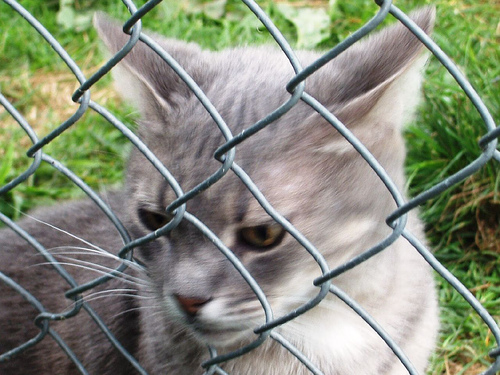

In [ ]:
output_image

## Section 3

LLM output

In [ ]:
# Please restart the notebook after running this cell
! pip install accelerate

  Using cached accelerate-0.28.0-py3-none-any.whl (290 kB)


In [ ]:
# Load any relevant LLM (You can use huggingface to load and perform other task)

from transformers import AutoModelForCausalLM

# Using Mistral model for this task
model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-v0.1", device_map="auto"
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/accelerate/utils/modeling.py:1363: UserWarning: Current model requires 603984384 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [ ]:
from transformers import AutoTokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1", padding_side="left")

tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [ ]:
# Generate the description for the input query

device = "cuda" if torch.cuda.is_available() else "cpu"
def generate_description(llm_model, input_query):
  # Add you code here
  model_inputs = tokenizer([input_query], return_tensors="pt").to(device)
  generated_ids = llm_model.generate(**model_inputs, max_new_tokens=5, do_sample=True)
  output_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=False, )[0]
  return output_text

In [ ]:
input_query = "A cat"

In [ ]:
# This cell taking too long to run since I am using CPU

llm_model = model
output_text = generate_description(llm_model, input_query)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [ ]:
output_text = generate_description(llm_model, input_query)
output_text

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'<s> A catastrophic injury is'